### 가장 가까운 초등학교 정보 컬럼 추가하기.

- 각각 원본 csv 파일에 열 방향으로 concat 하면 됨.
- 예 : dt = pd.concat([dt1, dt2], axis=1)

In [37]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

In [38]:
isTrainSelected = 1

if isTrainSelected:
    origin_filepath = '../train.csv'
    newXY_filepath = 'newXY_for_train.csv'
    target_filepath = 'elemSchool_for_train.csv'
else:
    origin_filepath = '../test.csv'
    newXY_filepath = 'newXY_for_test.csv'
    target_filepath = 'elemSchool_for_test.csv'

In [39]:
dt = pd.read_csv(origin_filepath)
dt_newXY = pd.read_csv(newXY_filepath)

dt = pd.concat([dt, dt_newXY], axis=1)
dt

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,좌표X_2,좌표Y_2
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,124000,127.056859,37.476276
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,123500,127.056859,37.476276
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,91500,127.056859,37.476276
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,130000,127.056859,37.476276
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,117000,127.056859,37.476276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200707,12,11,1998,...,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,20000,126.905543,37.612989
1118818,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200708,25,10,1998,...,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,20000,126.905543,37.612989
1118819,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200708,31,20,1998,...,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,28000,126.905543,37.612989
1118820,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200709,15,8,1998,...,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,29000,126.905543,37.612989


In [40]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape)

Train data shape :  (1118822, 54)


In [41]:
dt_elemSchool = pd.read_excel('../서울시_초등학교.xlsx')
dt_elemSchool

,학교명,위도,경도
0,서울대림초등학교,37.500615,126.924883
1,서울강일초등학교,37.565256,127.177286
2,서울양남초등학교,37.531123,127.089234
3,서울충무초등학교,37.561949,127.001235
4,서울잠동초등학교,37.518338,127.099931
...,...,...,...
600,청원초등학교,37.665252,127.062533
601,서울신계초등학교,37.629792,127.052769
602,서울도봉초등학교,37.679962,127.038289
603,서울백산초등학교,37.446740,126.905146


In [42]:
dt

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,좌표X_2,좌표Y_2
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,124000,127.056859,37.476276
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,123500,127.056859,37.476276
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,91500,127.056859,37.476276
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,130000,127.056859,37.476276
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,117000,127.056859,37.476276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200707,12,11,1998,...,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,20000,126.905543,37.612989
1118818,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200708,25,10,1998,...,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,20000,126.905543,37.612989
1118819,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200708,31,20,1998,...,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,28000,126.905543,37.612989
1118820,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200709,15,8,1998,...,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,29000,126.905543,37.612989


In [43]:
import numpy as np
from sklearn.neighbors import BallTree
from haversine import haversine, Unit

apartment_coords = dt[['좌표Y_2', '좌표X_2']].values
elemSchool_coords = dt_elemSchool[['위도', '경도']].values

tree = BallTree(elemSchool_coords, metric='haversine')
_, indices = tree.query(apartment_coords, k=1)  # distances 는 값이 이상하여 따로 계산하자.

distances = np.array([haversine((ac[0], ac[1]), (elemSchool_coords[i, 0], elemSchool_coords[i, 1]), unit=Unit.KILOMETERS)
                      for ac, i in zip(apartment_coords, indices)])

dt['최단거리초등학교명'] = dt_elemSchool.loc[indices.flatten(), '학교명'].values
dt['최단거리초등학교Km'] = distances

In [44]:
dt

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,좌표X_2,좌표Y_2,최단거리초등학교명,최단거리초등학교Km
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,124000,127.056859,37.476276,서울포이초등학교,0.385832
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,123500,127.056859,37.476276,서울포이초등학교,0.385832
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,91500,127.056859,37.476276,서울포이초등학교,0.385832
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,130000,127.056859,37.476276,서울포이초등학교,0.385832
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,117000,127.056859,37.476276,서울포이초등학교,0.385832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200707,12,11,1998,...,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,20000,126.905543,37.612989,서울구현초등학교,0.350313
1118818,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200708,25,10,1998,...,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,20000,126.905543,37.612989,서울구현초등학교,0.350313
1118819,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200708,31,20,1998,...,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,28000,126.905543,37.612989,서울구현초등학교,0.350313
1118820,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200709,15,8,1998,...,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,29000,126.905543,37.612989,서울구현초등학교,0.350313


In [45]:
display(dt['최단거리초등학교명'].isnull().sum())
display(dt['최단거리초등학교Km'].isnull().sum())

0

0

In [46]:
dt[['좌표X_2', '좌표Y_2', '최단거리초등학교명', '최단거리초등학교Km']]

,좌표X_2,좌표Y_2,최단거리초등학교명,최단거리초등학교Km
0,127.056859,37.476276,서울포이초등학교,0.385832
1,127.056859,37.476276,서울포이초등학교,0.385832
2,127.056859,37.476276,서울포이초등학교,0.385832
3,127.056859,37.476276,서울포이초등학교,0.385832
4,127.056859,37.476276,서울포이초등학교,0.385832
...,...,...,...,...
1118817,126.905543,37.612989,서울구현초등학교,0.350313
1118818,126.905543,37.612989,서울구현초등학교,0.350313
1118819,126.905543,37.612989,서울구현초등학교,0.350313
1118820,126.905543,37.612989,서울구현초등학교,0.350313


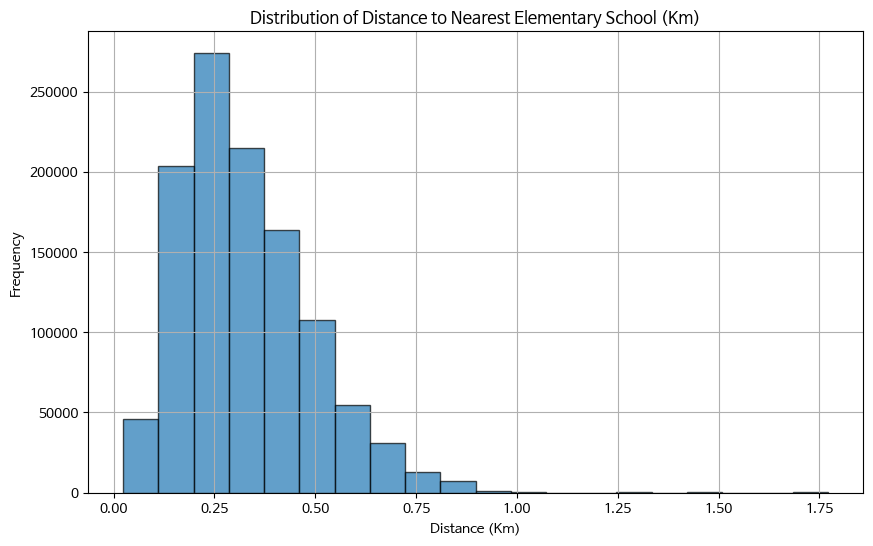

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# 히스토그램 그리기
plt.figure(figsize=(10, 6))
plt.hist(dt['최단거리초등학교Km'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Distance to Nearest Elementary School (Km)')
plt.xlabel('Distance (Km)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [48]:
dt[['최단거리초등학교명', '최단거리초등학교Km']].to_csv(target_filepath, encoding='utf-8-sig', index=False)